房價預測模型

### Import必要套件

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### 數據讀取並分析

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/TFkeras/kc_house_data.csv')
# 顯示dataset的形狀，共21613比資料，每一比資料有21種不同資訊。
data.shape

(21613, 21)

In [ ]:
# 將顯示列數設定為25，不然會有部份資料無法顯示
pd.options.display.max_columns = 25
# head 會顯示前五行的數據
data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


各個數據的簡寫分別代表下面意思：
- date：房屋出售日期。
- price：房屋價格（目標）。
- bedrooms：臥室數量。
- bathrooms：浴室數量。
- sqft_living：居住的坪數（平方英尺）。
- sqft_lot：實際的坪數（平方英尺）。
- floors：房屋總共樓層。
- waterfront：海景房。
- view：房屋是否看過。
- condition：整體條件有多好。
- grade：房屋的整體等級（根據King County評分系統）。
- sqft_above：除了地下室外的坪數（平方英尺）。
- sqft_basement：地下室的坪數（平方英尺）。
- yr_built：房屋建造時間。
- yr_renovated：何時重新裝修過（一些沒重新裝修過或是裝修紀錄沒被記錄到的數值都為0）。
- zipcode：郵政編碼。
- lat：緯度座標。
- long：經度座標。
- sqft_living15：2015年紀錄的居住坪數（可能是翻新的原因導致sqft_living15與sqft_living不同）。
- sqft_lot15：2015年紀錄的實際坪數（可能是翻新的原因導致sqft_lot15與sqft_lot不同）。

### 檢查資料的型態

資料型態總共有五種：object(string),booleab, integer, float and categorical.

In [ ]:
data.dtypes

,0
id,int64
date,object
price,float64
bedrooms,int64
bathrooms,float64
sqft_living,int64
sqft_lot,int64
floors,float64
waterfront,int64
view,int64


### 數據前處理
轉換資料型態：
因為數據集裡的date數據是字串（string）格式，而模型的輸入只接受數值格式，所以可以透過以下程式碼將其轉為數值，並分成年、月及日三種數據。

In [ ]:
# 將date日期拆為年、月和日並轉成數值
data['year'] = pd.to_numeric(data['date'].str.slice(0, 4))
data['month'] = pd.to_numeric(data['date'].str.slice(4, 6))
data['day'] = pd.to_numeric(data['date'].str.slice(6, 8))

# 刪除沒有用的數據，inplace則是將更新後的資料存回原本的地方
data.drop(['id'], axis="columns", inplace=True)
data.drop(['date'], axis="columns", inplace=True)

data.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,year,month,day
0,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650,2014,10,13
1,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639,2014,12,9
2,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062,2015,2,25
3,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000,2014,12,9
4,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503,2015,2,18


分割數據集（Dataset）：將數據集切割成三個部份，訓練數據（Training data）、驗證數據（Validation data）和測試數據（Testing data）。

In [ ]:
data_num = data.shape[0]
# 取得一筆與data數量相同的亂數索引，主要目的是用於打散資料
indexes = np.random.permutation(data_num)
# 並將亂數索引值分為Train、validation和test分為，這裡的劃分比例為6:2:2
train_indexes = indexes[:int(data_num *0.6)]
val_indexes = indexes[int(data_num *0.6):int(data_num *0.8)]
test_indexes = indexes[int(data_num *0.8):]
# 透過索引值從data取出訓練資料、驗證資料和測試資料
train_data = data.loc[train_indexes]
val_data = data.loc[val_indexes]
test_data = data.loc[test_indexes]

### Normalization 正規化

使用標準分數(Standard Score, 又稱z-score)將數據正規化，經過z-score正規化後數據的都會聚集在0附近， 標準差為1。

(x - 平均值) / 標準差

In [ ]:
train_validation_data = pd.concat([train_data, val_data])
mean = train_validation_data.mean() # shape: (1, 25)
std = train_validation_data.std()

train_data = (train_data - mean) / std # column
val_data = (val_data - mean) / std

### 建立data frame格式的訓練數據

In [ ]:
x_train = train_data.drop('price', axis='columns') #X特徵
y_train = train_data['price'] #Y預測
x_val = val_data.drop('price', axis='columns')
y_val = val_data['price']

整理過後的資料共12967筆，且一筆資料有21種資訊(所以網路輸入必須為21)。

In [ ]:
x_train.shape

(12967, 21)

In [ ]:
x_train

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,year,month,day
20831,-0.395870,0.172991,-0.529919,-0.338020,2.774944,-0.084989,-0.305496,-0.632347,0.294985,-0.237937,-0.655292,1.460909,-0.211591,1.080746,-0.143462,-1.233904,-0.504865,-0.418580,1.454563,-1.469592,0.851000
4204,-0.395870,0.496343,0.995336,-0.197399,-0.917294,-0.084989,-0.305496,-0.632347,-0.560338,-0.286414,2.597750,1.086640,-0.211591,0.521333,-0.262613,-0.990925,-0.270172,-0.216509,-0.687452,1.414618,-0.771977
17935,-0.395870,-0.473714,0.112867,-0.213061,-0.917294,-0.084989,2.315204,-0.632347,0.294985,-0.492442,1.151954,-0.750678,-0.211591,2.255515,0.650154,-1.362540,0.052530,-0.240572,1.454563,-1.469592,0.155439
14060,0.673932,-0.473714,0.047499,-0.176973,0.928825,-0.084989,-0.305496,-0.632347,0.294985,0.404387,-0.655292,-0.002141,4.740928,1.640160,-0.744271,-0.940900,-0.240835,-0.185030,-0.687452,1.414618,-0.308269
15599,0.673932,1.466399,2.531486,4.134929,0.928825,-0.084989,-0.305496,0.903010,1.150309,3.167591,-0.655292,0.746396,-0.211591,-1.045025,-2.894040,1.839060,0.433906,6.460189,-0.687452,-0.187721,-1.583465
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1229,0.673932,1.143047,0.788337,-0.171560,0.928825,-0.084989,-0.305496,-0.632347,0.294985,1.228500,-0.655292,1.052616,-0.211591,-0.746671,-1.485172,1.438860,1.196658,-0.208871,-0.687452,1.414618,-0.424196
3356,0.673932,0.172991,0.276287,-0.108863,0.928825,-0.084989,-0.305496,0.903010,0.294985,0.658893,-0.655292,-0.206288,-0.211591,-1.362026,0.320143,0.331164,-0.152826,-0.156110,-0.687452,1.414618,0.271366
1726,-0.395870,-0.473714,-0.344710,-0.180293,-0.917294,-0.084989,-0.305496,0.903010,0.294985,-0.031908,-0.655292,-0.172263,-0.211591,-1.026378,-1.784855,-1.105268,0.023194,-0.189479,-0.687452,-0.187721,0.851000
17355,1.743733,0.496343,0.025709,-0.013977,-0.917294,-0.084989,-0.305496,-0.632347,-0.560338,-0.783306,1.513403,0.406152,-0.211591,1.435042,1.532592,-0.733654,-0.226167,-0.144987,1.454563,-1.149125,-0.192342


### 建立並訓練網路模型

這裡建構三層全連接層的網路架構，並且使用ReLU作為隱藏層的激活函數，而由於需得到線性輸出，故輸出層不使用任何激活函數。

In [ ]:
# 建立一個Sequential型態的model
model = keras.Sequential(name='model-1')
# 第1層全連接層設為64個unit，將輸入形狀設定為(21, )，而實際上我們輸入的數據形狀為(batch_size, 21)
model.add(layers.Dense(64, activation='relu', input_shape=(21,)))
# 第2層全連接層設為64個unit
model.add(layers.Dense(64, activation='relu'))
# 最後一層全連接層設為1個unit
model.add(layers.Dense(1))
# 顯示網路模型架構
model.summary()

#param權重= output shape * (上一層的output Shape + 1)
#最上層的權重= output shape * (input shape + 1)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "model-1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         1,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,633 (22.00 KB)

 Trainable params: 5,633 (22.00 KB)

 Non-trainable params: 0 (0.00 B)

設定訓練使用的優化器、損失函數和指標函數：

In [ ]:
model.compile(keras.optimizers.Adam(0.001), #(學習率)
              loss=keras.losses.MeanSquaredError(),
              metrics=[keras.metrics.MeanAbsoluteError()])

創建模型儲存目錄：

In [ ]:
model_dir = 'lab1-logs/models/'
os.makedirs(model_dir)

設定回調函數：

In [ ]:
# TensorBoard回調函數會幫忙紀錄訓練資訊，並存成TensorBoard的紀錄檔
log_dir = os.path.join('lab1-logs', 'model-1')
model_cbk = keras.callbacks.TensorBoard(log_dir=log_dir)
# ModelCheckpoint回調函數幫忙儲存網路模型，可以設定只儲存最好的模型，「monitor」表示被監測的數據，「mode」min則代表監測數據越小越好。
model_mckp = keras.callbacks.ModelCheckpoint(model_dir + '/Best-model-1.keras',
                                        monitor='val_mean_absolute_error',
                                        save_best_only=True,
                                        mode='min')

訓練網路模型：

In [ ]:
history = model.fit(x_train, y_train,  # 傳入訓練數據
               batch_size=64,  # 批次大小設為64
               epochs=100,  # 整個dataset訓練100遍
               validation_data=(x_val, y_val),  # 驗證數據
               callbacks=[model_cbk, model_mckp])  # Tensorboard回調函數紀錄訓練過程，ModelCheckpoint回調函數儲存最好的模型

Epoch 1/100
203/203 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.4295 - mean_absolute_error: 0.4112 - val_loss: 0.2518 - val_mean_absolute_error: 0.2992
Epoch 2/100
203/203 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.1965 - mean_absolute_error: 0.2798 - val_loss: 0.2206 - val_mean_absolute_error: 0.2828
Epoch 3/100
203/203 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1716 - mean_absolute_error: 0.2609 - val_loss: 0.2018 - val_mean_absolute_error: 0.2743
Epoch 4/100
203/203 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1569 - mean_absolute_error: 0.2486 - val_loss: 0.1807 - val_mean_absolute_error: 0.2502
Epoch 5/100
203/203 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1422 - mean_absolute_error: 0.2357 - val_loss: 0.1722 - val_mean_absolute_error: 0.2400
Epoch 6/100
203/203 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1384 - mean_absolute_error: 0.2289 - val_loss: 0.1579 - val_mean_absolute_error: 0.2338
Epoch 7/100
203/203 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1220 - mean_absolute_error: 0.

### 訓練結果

In [ ]:
history.history.keys()  # 查看history儲存的資訊有哪些

dict_keys(['loss', 'mean_absolute_error', 'val_loss', 'val_mean_absolute_error'])

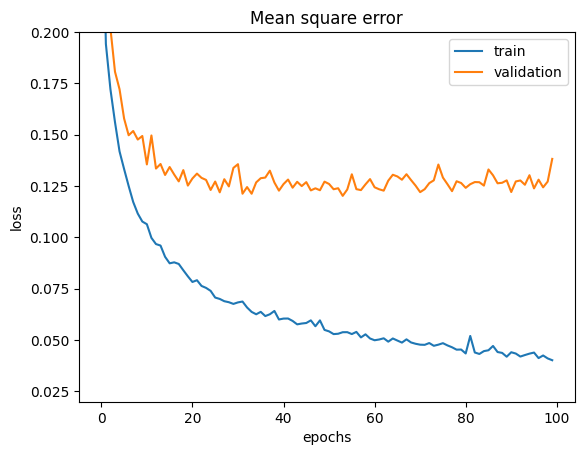

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.ylim(0.02, 0.2)
plt.title('Mean square error')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')

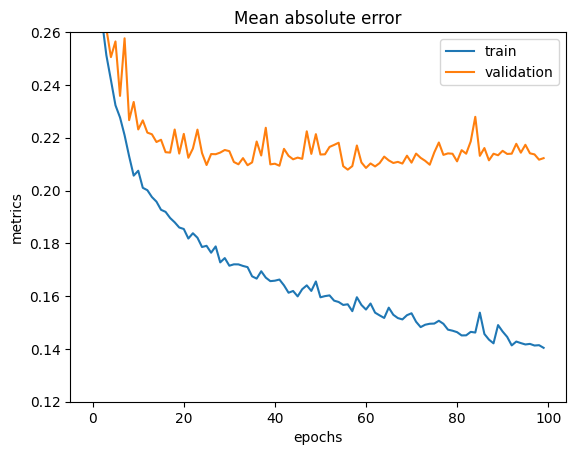

In [ ]:
plt.plot(history.history['mean_absolute_error'], label='train')
plt.plot(history.history['val_mean_absolute_error'], label='validation')
plt.ylim(0.12, 0.26)
plt.title('Mean absolute error')
plt.ylabel('metrics')
plt.xlabel('epochs')
plt.legend(loc='upper right')

測試數據的誤差百分比：用測試數據預測房屋價格並與答案計算誤差百分比。

In [ ]:
# 載入模型
model = keras.models.load_model('lab1-logs/models/Best-model-1.h5')
# 先將房屋價格取出
y_test = test_data['price']
print(y_test.shape)
# 標準化數據
test_data = (test_data - mean) / std
# 將輸入數據存成Numpy 格式 # not necessary
x_test = test_data.drop('price', axis='columns') # check shape
# 預測測試數據
y_pred = model.predict(x_test)
print(y_pred.shape)

# 將預測結果轉換回來(因為訓練時的訓練目標也有經過標準化)
y_pred = y_pred * std['price'] + mean['price']
y_pred = y_pred.reshape(y_test.shape)
print(y_pred.shape, y_test.shape)
# 計算平均的誤差百分比
percentage_error = np.mean(np.abs(y_test - y_pred) / y_test) * 100
# 顯示誤差百分比
print("Model_1 Percentage Error: {:.2f}%".format(percentage_error))

(4323,)
136/136 [==============================] - 0s 2ms/step
(4323, 1)
(4323,) (4323,)
Model_1 Percentage Error: 14.38%


In [ ]:
# 直接使用model.evaluate 結果MAE不同??Why??
test_mse_score, test_mae_score = model.evaluate(x_test, test_data['price'])

136/136 [==============================] - 1s 3ms/step - loss: 0.1290 - mean_absolute_error: 0.2015


In [ ]:
test_mae_score

0.2014765441417694

### TensorBoard 可視化工具

In [ ]:
# 這行指令可以幫助我們直接在jupyter notebook上顯示TensorBoard or http://localhost:6006/
%load_ext tensorboard

In [ ]:
%tensorboard --logdir lab1-logs --host=127.0.0.1

<IPython.core.display.Javascript object>

Reference: https://github.com/taipeitechmmslab/MMSLAB-TF2